In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import json

import cv2
import torch
from tqdm import tqdm_notebook
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
import torchvision

META_DIR = "data/metadata/metadata/"
TRAIN_DIR = "data/train/train/"
TEST_DIR = "data/test/test/"

test_data = json.load(open(META_DIR + 'iwildcam2022_test_information.json'))
train_data = json.load(open(META_DIR + 'iwildcam2022_train_annotations.json'))

#Test images
df_test = pd.DataFrame({'id': [item['id'] for item in test_data['images']],
                                'seq_id': [item['seq_id'] for item in test_data['images']],
                                'file_name': [item['file_name'] for item in test_data['images']],
                                'location': [item['location'] for item in test_data['images']],
                                'seq_num_frames': [item['seq_num_frames'] for item in test_data['images']],
                                'seq_frame_num': [item['seq_frame_num'] for item in test_data['images']]})
#Train images
df_train = pd.DataFrame({'id': [item['id'] for item in train_data['images']],
                                'seq_id': [item['seq_id'] for item in train_data['images']],
                                'file_name': [item['file_name'] for item in train_data['images']],
                                'location': [item['location'] for item in train_data['images']],
                                'seq_num_frames': [item['seq_num_frames'] for item in train_data['images']],
                                'seq_frame_num': [item['seq_frame_num'] for item in train_data['images']]})
# Detection for train test
detections = json.load(open(META_DIR+"iwildcam2022_mdv4_detections.json"))['images']
det_dict = dict()
for detection in tqdm(detections):
    det_dict[detection['file']] = detection['detections']
df_detection = pd.DataFrame({'file': [item['file'] for item in detections],
                                'detections': [item['detections'] for item in detections]})
# Test sequence ids
test_sequence_ids = pd.unique(df_test['seq_id'])
# Train sequence id and count
train_seq_count = pd.read_csv(META_DIR+"train_sequence_counts.csv")

/home/briancy2/.conda/envs/iwildcam/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 261428/261428 [00:00<00:00, 1518777.16it/s]


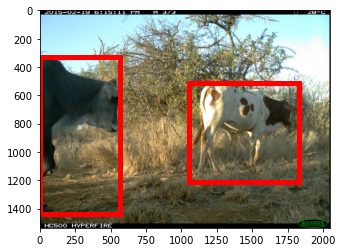

In [2]:
from visualization import visualize_seq

seq_id = '94f7be22-21bc-11ea-a13a-137349068a90'
visualize_seq(df_train, df_detection, seq_id, TRAIN_DIR)
